# Table of Contents
* [Explore TQA](#Explore-TQA)
	* [load](#load)
* [extract sentences](#extract-sentences)
	* [counts](#counts)
* [Explore existing](#Explore-existing)


In [1]:
import numpy as np
import pandas as pd
import scipy as st

import pickle
from collections import defaultdict
import json
import os
import random
from copy import deepcopy

In [2]:
import nltk
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [3]:
%%capture
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
#%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

# Explore TQA

## load

In [4]:
dataset_root_dir = './data_sources/'
tqa_file = 'tqa_v10_no_sa.json'
data_path =  os.path.join(dataset_root_dir, tqa_file)

with open(os.path.join(data_path), 'r') as f:
    ck12_combined_dataset_raw = json.load(f)

ck12_combined_dataset = deepcopy(ck12_combined_dataset_raw)

## extract sentences

In [5]:
def dict_key_extract(key, var):
    if hasattr(var, 'items'):
        for k, v in var.items():
            if k == key:
                yield v
            if isinstance(v, dict):
                for result in dict_key_extract(key, v):
                    yield result
            elif isinstance(v, list):
                for d in v:
                    for result in dict_key_extract(key, d):
                        yield result

In [6]:
lessons_paragraphs = {lesson['globalID']: list(dict_key_extract('text', lesson)) for lesson in ck12_combined_dataset}

In [7]:
fp = list(lessons_paragraphs.values())[0][0]

In [8]:
all_sentences = []

In [9]:
for topic in list(lessons_paragraphs.values()):
    for par in topic:
        topic_sentences = sent_tokenize(par)
        topic_sentences  = [sent for sent in topic_sentences if  len(sent) > 10 and sent[-1] == '.']
        all_sentences += topic_sentences

In [10]:
cause_phrases = [' cause', 'leads to', 'produces', 'generates', ' create', 'due to']

In [11]:
cause_sents = [sent for sent in all_sentences if ' cause' in sent.lower()]

In [12]:
leads_sents = [sent for sent in all_sentences if ' leads to' in sent.lower()]

In [13]:
produces_sents = [sent for sent in all_sentences if ' produces' in sent.lower()]

In [14]:
generates_sents = [sent for sent in all_sentences if 'generates' in sent.lower()]

In [15]:
all_sents = [sent for sent in all_sentences if any(phrase in sent.lower() for phrase in cause_phrases)]
len(all_sents)

2242

In [16]:
cause_and_proceed = []
for idx, sent in enumerate(all_sentences):
    if ' cause' in sent.lower() and 'this' in sent.lower():
        cause_and_proceed.append((all_sentences[idx - 1], sent))

## counts

In [9]:
all_counts = []
for lesson_text in list(lessons_paragraphs.values()):
    topic_counts = [topic for topic in lesson_text if 'cause' in topic]
    all_counts.append(topic_counts)

In [10]:
all_counts[30][3]

'Natural processes caused earlier climate changes. Human beings are the main cause of recent global warming. '

In [11]:
flat_counts = [item for sublist in all_counts for item in sublist]

In [12]:
sum(flat_counts)

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [13]:
count_series = pd.Series(all_counts)

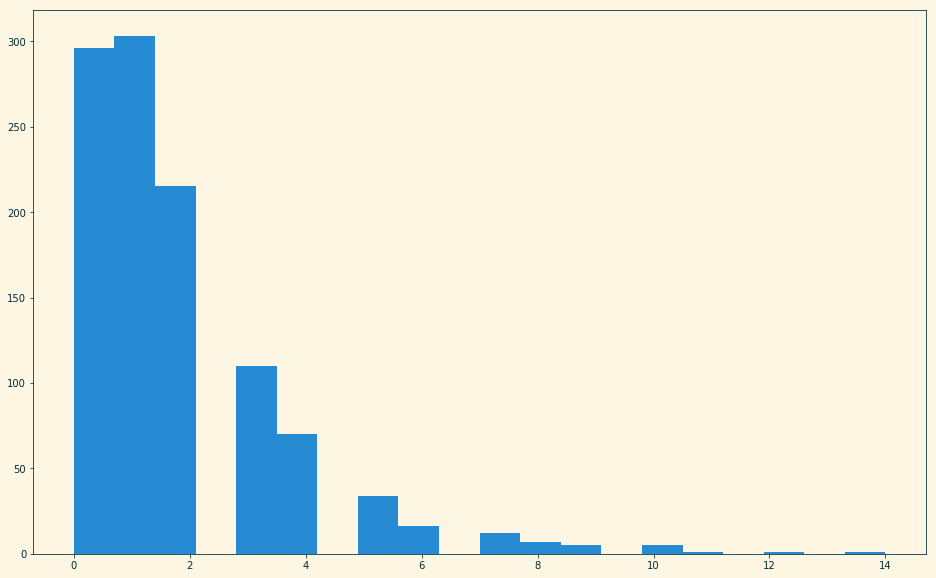

In [14]:
_ = count_series.apply(lambda x: len(x)).hist(bins = 20)

# Explore Omnibus Questions

In [57]:
dataset_root_dir = './data_sources/'
omni_file = 'Omnibus 4 NDMC Train Topic+Category Performance [For a good cause] - Aristo per 2016%2F06%2F24.csv'
omni_path =  os.path.join(dataset_root_dir, omni_file)

omni_df = pd.read_csv(omni_path, error_bad_lines=False)
omni_df = omni_df.fillna('NA')
omni_cause_df

omni_cause_df = omni_df[omni_df['Category'].str.contains('causality')]
omni_df_working = omni_cause_df[['QID', 'AnswerKey', 'QuestionText']]

In [60]:
omni_df.shape

(1201, 43)

In [58]:
omni_df_working.head()

,QID,AnswerKey,QuestionText
2,AKDE&ED_2008_4_14,A,The length of daylight changes as the seasons ...
5,AKDE&ED_2012_4_10,B,Which action most likely causes large rocks to...
12,CSZ10356,B,Which of the following gases do plants use in ...
17,CSZ20059,D,Which action will result in a product with new...
19,CSZ10373,C,Which of the following processes is responsibl...


# Explore existing KBs

In [74]:
cause_rel_tables_df = pd.read_csv(dataset_root_dir + 'cause_relations_from_tables.tsv', sep='\t', header=None)
cause_rel_tables_df.columns = ['cause', '_', 'effect', 'source']
cause_rel_tables_df = cause_rel_tables_df[['cause', 'effect', 'source']]

In [82]:
cause_ferret = pd.read_csv(dataset_root_dir + 'CAUSE-extracted-by-Ferret-from-WebSentences.tsv', sep='\t', header=None)
effect_ferret = pd.read_csv(dataset_root_dir + 'EFFECT-extracted-by-Ferret-from-WebSentences.tsv', sep='\t', header=None)
cause_ferret.columns = ['cause', '_', 'effect', 'source']
cause_ferret = cause_ferret[['cause', 'effect', 'source']]

In [88]:
concept_net = pd.read_csv(dataset_root_dir + 'conceptnet-causal-db.tsv', sep='\t', header=None)
concept_net.columns = ['cause', '_', 'effect']
concept_net = concept_net[['cause', 'effect']]